In [ ]:
import sys
import random

import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import importlib
from einops import rearrange, reduce, repeat
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def unfold_output_size(n_times, patches, step):
    return (n_times - patches) / step + 1

In [ ]:
from modules.BciDataHandler import BciDataHandler

data_handler = BciDataHandler()
data_handler.instantiate_dataset()

In [ ]:
# ------------------------------ bci competition dataset ------------------------------
all_subject_epochs = mne.concatenate_epochs(list(data_handler.subjects_epochs.values()))
all_labels = all_subject_epochs.events[:, -1] - 1

epochs = data_handler.subjects_epochs[1]
labels = np.array(data_handler.subjects_labels[1]) - 1

# epochs = all_subject_epochs
# labels = all_labels
# labels

In [ ]:
# -------------------------------- ufjf dataset --------------------------------------
# from modules.EdfHandler import EdfHandler
#
# epochs, labels = EdfHandler.getAllData(["C:\\Users\\davi2\Desktop\\bci\\datasets_ufjf\\bci\\001.edf"])
# epochs = epochs[0]
# labels = np.array(labels[0])
# labels[labels == 6] = 0

In [ ]:
#----------------------- physionet dataset -------------------------------------
# import mne
# from mne import Epochs, pick_types, events_from_annotations
# from mne.channels import make_standard_montage
# from mne.io import concatenate_raws, read_raw_edf
# from mne.datasets import eegbci
#
#
# #############################################################################
# # Set parameters and read data
#
# # avoid classification of evoked responses by using epochs that start 1s after
# # cue onset.
# tmin, tmax = -1., 4.
# event_id = dict(handsOrLeft=2, feetOrRight=3)
#
# def get_physionet_data(subject, runs):
#
#     raw_fnames = eegbci.load_data(subject, runs)
#     raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
#     eegbci.standardize(raw)  # set channel names
#     montage = make_standard_montage('standard_1005')
#     raw.set_montage(montage)
#
#     # Apply band-pass filter
#     raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
#
#     events, _ = events_from_annotations(raw)
#
#     picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
#                        exclude='bads')
#
#     # Read epochs (train will be done only between 1 and 2s)
#     # Testing will be done with a running classifier
#     epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
#                     baseline=None, preload=True)
#
#     epochs_data = epochs.copy().crop(tmin=1., tmax=2.)
#
#     labels = epochs.events[:, -1] - 2
#
#     return epochs_data, labels
#
#
# # [6, 10, 14] hands vs feet
# # [4, 8, 12] left vs right hand
# X_hf, y_hf = get_physionet_data(subject=1, runs=[6, 10, 14])
# X_lr, y_lr = get_physionet_data(subject=1, runs=[4, 8, 12])
#
# epochs = mne.concatenate_epochs([X_hf, X_lr])
# labels = np.concatenate([y_hf, y_lr+2])

In [ ]:
# def plot_psd(data, axis, label, color):
#     psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq,
#                                                           fmin=0.1, fmax=100)
#     psds = 10. * np.log10(psds)
#     psds_mean = psds.mean(0).mean(0)
#     axis.plot(freqs, psds_mean, color=color, label=label)
#
#
# _, ax = plt.subplots()
# plot_psd(X, ax, 'original', 'k')
# plot_psd(X_tr.numpy(), ax, 'shifted', 'r')
#
# ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
#        ylabel='Power Spectral Density (dB)')
# ax.legend()
# plt.show()

In [ ]:
def exists(val):
    return val is not None

class MyViTransformerWrapper(nn.Module):
    def __init__(
            self,
            *,
            image_size,
            patch_size,
            attn_layers,
            channels,
            num_classes = None,
            dropout = 0.,
            post_emb_norm = False,
            emb_dropout = 0.
    ):
        super().__init__()
        assert isinstance(attn_layers, Encoder), 'attention layers must be an Encoder'
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        dim = attn_layers.dim
        num_patches = (image_size // patch_size)
        patch_dim = channels * patch_size

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(num_patches, dim))

        self.patch_to_embedding = nn.Sequential(
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.post_emb_norm = nn.LayerNorm(dim) if post_emb_norm else nn.Identity()
        self.dropout = nn.Dropout(emb_dropout)

        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)
        self.mlp_head = nn.Linear(dim, num_classes) if exists(num_classes) else nn.Identity()

    def forward(
            self,
            img,
            return_embeddings = False
    ):
        p = self.patch_size
        img = img.unsqueeze(-2)
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 1, p2 = p)
        x = self.patch_to_embedding(x)
        n = x.shape[1]
        x = x + self.pos_embedding

        x = self.post_emb_norm(x)
        x = self.dropout(x)

        x = self.attn_layers(x)
        x = self.norm(x)

        if not exists(self.mlp_head) or return_embeddings:
            return x

        x = x.mean(dim = -2)
        return self.mlp_head(x)

In [ ]:
from utils.utils import initialize_weight
from base.layers import Conv2dWithConstraint
import math

import torch
from torch import nn
import torch.nn.functional as F
import torch
from x_transformers import TransformerWrapper, Encoder, ViTransformerWrapper


class FeatureExtraction(nn.Module):
    def __init__(
            self,
            n_channels,
            kernel_length,
            F1,
            D,
            F2,
            pool1_stride,
            pool2_stride,
            dropout_rate,
            weight_init_method=None
    ):
        super().__init__()
        pooling_layer = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)['mean']

        if F2 == 'auto':
            F2 = F1 * D

        # Spectral
        self.spectral = nn.Sequential(
            Rearrange('b c w -> b 1 c w'),
            nn.Conv2d(1, F1, (1, kernel_length), bias=False, padding='same'),
            nn.BatchNorm2d(F1)
        )

        # Spatial
        self.spatial = nn.Sequential(
            Conv2dWithConstraint(F1, F1 * D, (n_channels, 1), bias=False, groups=F1),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            pooling_layer((1, pool1_stride)),
            nn.Dropout(dropout_rate)
        )

        # Temporal
        self.temporal = nn.Sequential(
            nn.Conv2d(F1 * D, F2, (1, n_channels), bias=False, padding='same', groups=F1 * D),
            nn.Conv2d(F2, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            pooling_layer((1, pool2_stride)),
            nn.Dropout(dropout_rate)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
        )

        initialize_weight(self, weight_init_method)

    def forward(self, x):
        out = self.spectral(x)
        out = self.spatial(out)
        out = self.temporal(out)
        out = self.classifier(out)
        return out


In [241]:
from base.layers import LinearWithConstraint
from einops.layers.torch import Reduce
from x_transformers import ContinuousTransformerWrapper
from einops.layers.torch import Rearrange

class EEGNET(nn.Module):
    def __init__(
            self,
            n_times,
            n_classes,
            n_channels,
            patches_size=9,
            transformer_dim=32,
            transformer_layers=1,
            transformer_heads=1,
            dropout_rate=0.5,
            max_norm=0.25,
            F1=8,
            F2=16,
            D=2,
            pool1_stride=4,
            pool2_stride=8,
            kernel_length=64,
            n_hidden=64,
    ):
        super().__init__()

        self.feature_extraction_output = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1)

        self.feature_extraction = nn.Sequential(
            FeatureExtraction(n_channels=n_channels, kernel_length=kernel_length, F1=F1, D=D, F2=F2, pool1_stride=pool1_stride, pool2_stride=pool2_stride, dropout_rate=dropout_rate),
            nn.Linear(in_features=self.feature_extraction_output, out_features=n_hidden),
            nn.ELU(),
        )

        self.transformer = nn.Sequential(
            MyViTransformerWrapper(
                image_size=n_times,
                patch_size=patches_size,
                channels=n_channels,
                dropout=dropout_rate,
                attn_layers=Encoder(
                    dim=transformer_dim,
                    depth=transformer_layers,
                    heads=transformer_heads,
                    macaron=True,
                    rel_pos_bias=True
                ),
            ),
            nn.Linear(in_features=transformer_dim, out_features=n_hidden),
            nn.ELU(),
        )

        self.spatial_transformer = nn.Sequential(
            nn.AdaptiveAvgPool1d(64), #layer do stop overfit
            Rearrange("b c t -> b t c"),
            MyViTransformerWrapper(
                image_size=n_channels,
                patch_size=n_channels//2,
                channels=64,
                dropout=dropout_rate,
                attn_layers=Encoder(
                    dim=transformer_dim,
                    depth=transformer_layers,
                    heads=transformer_heads,
                    macaron=True,
                    rel_pos_bias=True
                ),
            ),
            nn.LayerNorm(transformer_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=transformer_dim, out_features=n_hidden),
            nn.ELU(),
        )

        self.head = nn.Sequential(
            LinearWithConstraint(in_features=3*n_hidden, out_features=n_classes, max_norm=max_norm),
        )

    def forward(self, x, targets):
        out_values = {}
        feature_extraction_result = self.feature_extraction(x)
        transformer_result = self.transformer(x)
        spatial_transformer_result = self.spatial_transformer(x)
        logits = self.head(torch.cat([
            feature_extraction_result,
            transformer_result,
            spatial_transformer_result
        ], dim=-1))

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss, out_values

In [242]:
#data augmentation
from braindecode.augmentation import FrequencyShift
from braindecode.augmentation import GaussianNoise

sfreq = epochs.info['sfreq']

freq_shift = FrequencyShift(
    probability=0.5,  # defines the probability of actually modifying the input
    sfreq=sfreq,
    max_delta_freq=2.  # the frequency shifts are sampled now between -2 and 2 Hz
)

gauss_noise = GaussianNoise(
    probability=0.5,
    std=0.01
)

transforms = {
    'freq': freq_shift,
    'gauss': gauss_noise
}

In [243]:
data = epochs.get_data()
X = torch.tensor(data).to(dtype=torch.float32, device=device)
y = torch.tensor(labels).to(dtype=torch.long, device=device)

In [244]:
model = EEGNET(n_times=X.shape[-1], n_channels=len(epochs.picks), n_classes=len(set(labels)))
model = model.to(device=device)

In [245]:
seed = 1330
splits = 5
lr=3e-4

skf = StratifiedKFold(n_splits=splits, random_state=seed, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [246]:
#fine tune
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

loss: 1.4039393663406372 iteration: 100/2000


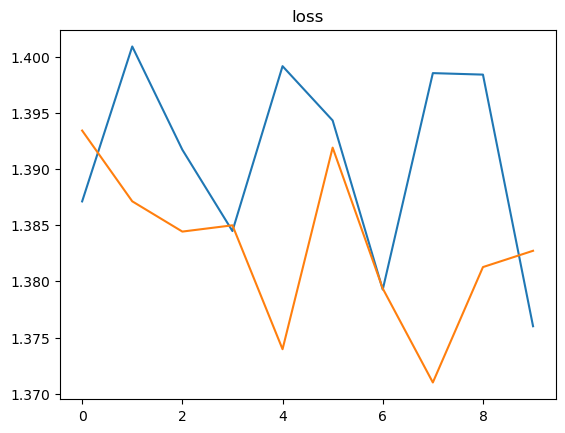

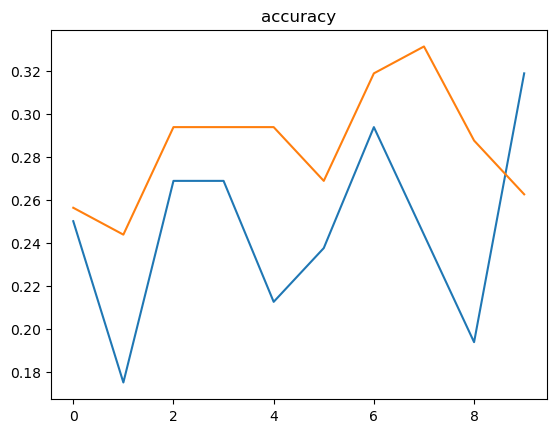

loss: 1.2789770364761353 iteration: 200/2000


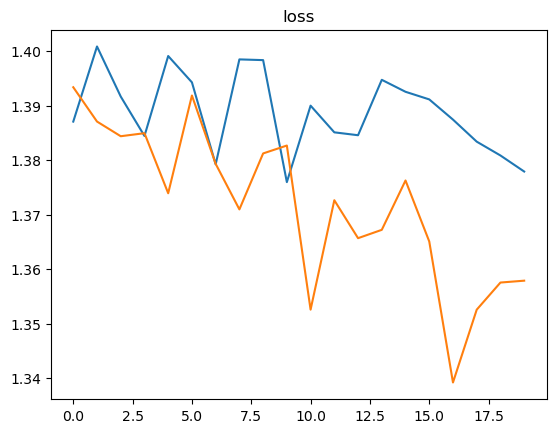

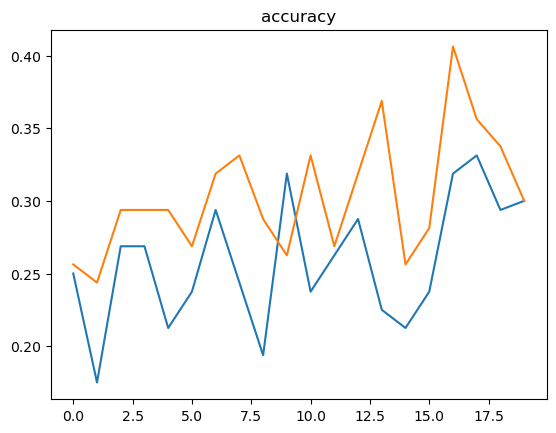

loss: 1.1565558910369873 iteration: 300/2000


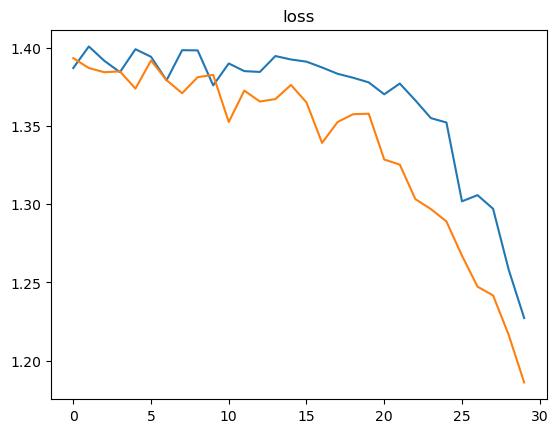

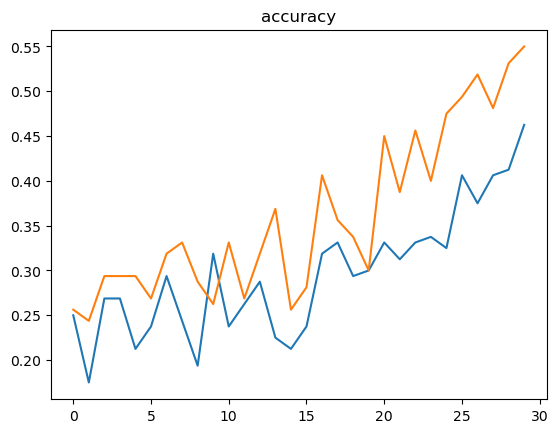

loss: 0.9133591055870056 iteration: 400/2000


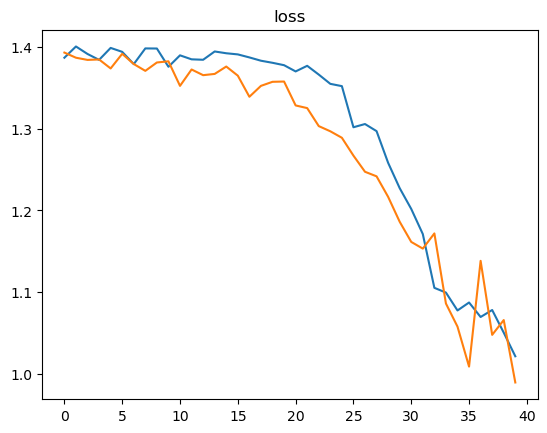

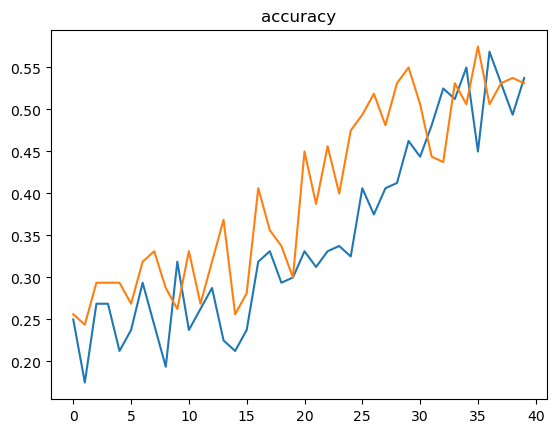

loss: 0.9268835783004761 iteration: 500/2000


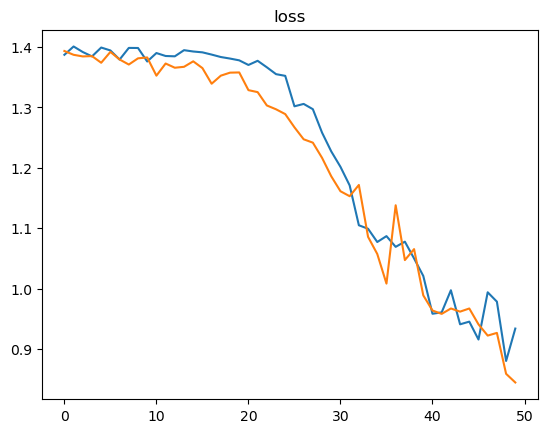

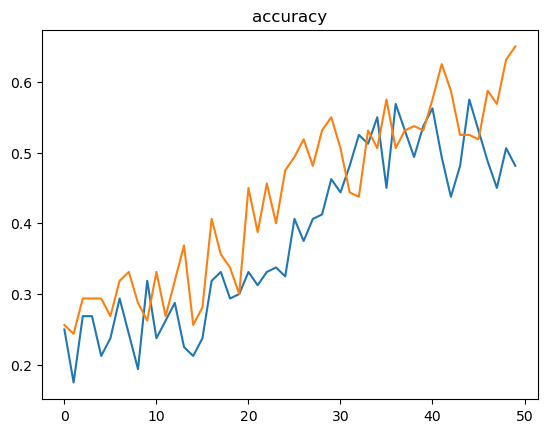

loss: 0.6528182029724121 iteration: 600/2000


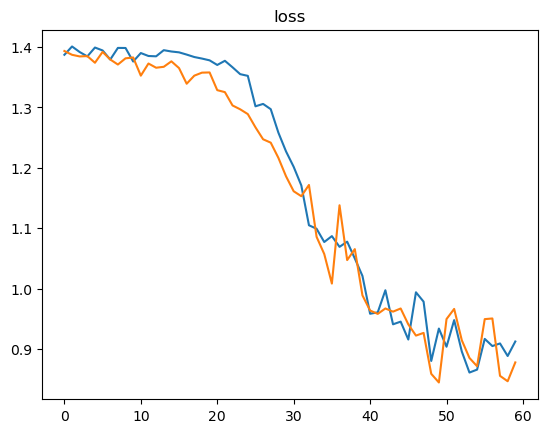

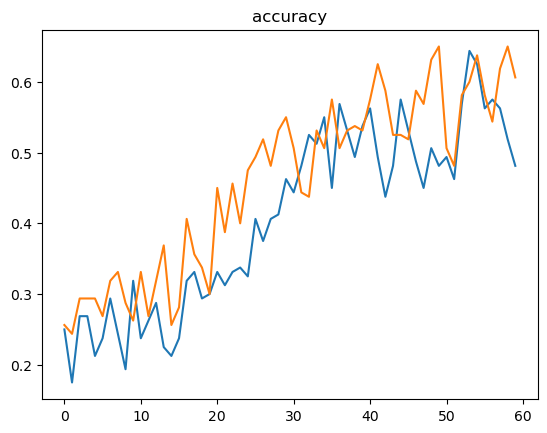

loss: 0.9079951643943787 iteration: 700/2000


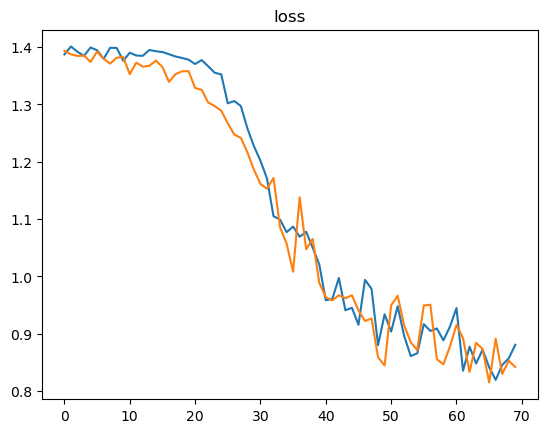

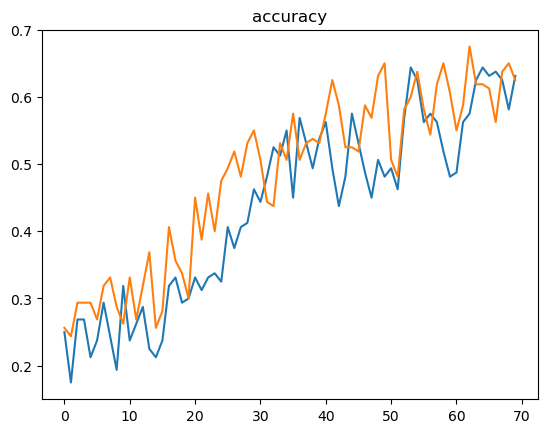

loss: 0.8436623811721802 iteration: 800/2000


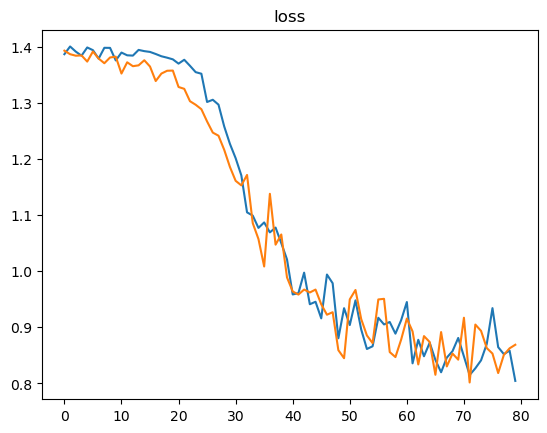

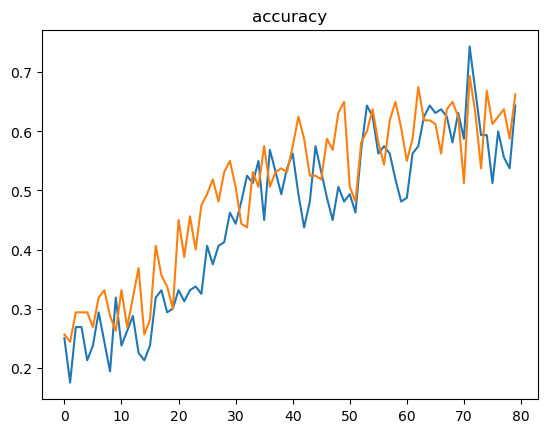

loss: 0.665431022644043 iteration: 900/2000


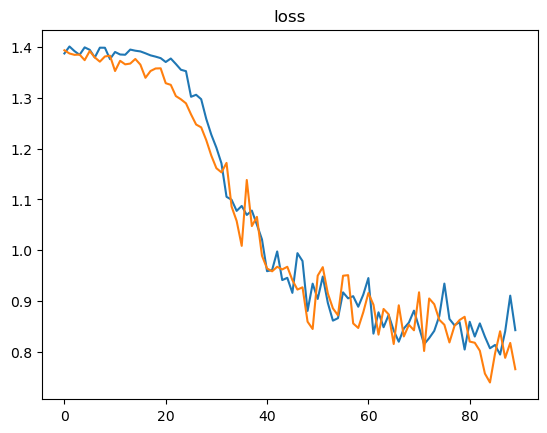

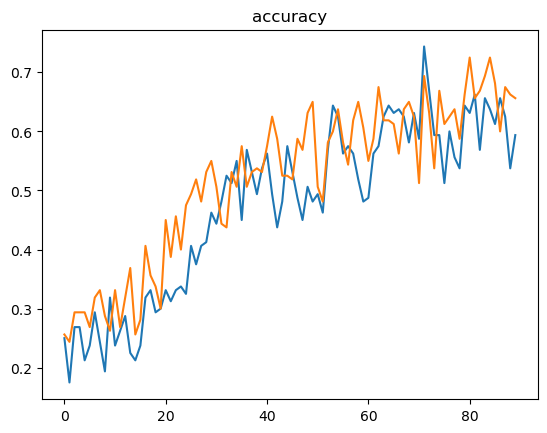

loss: 0.9109429717063904 iteration: 1000/2000


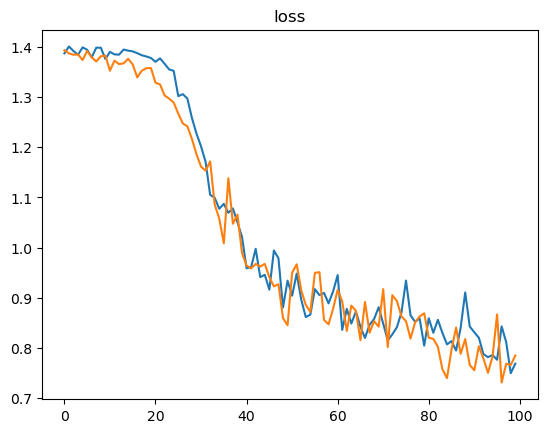

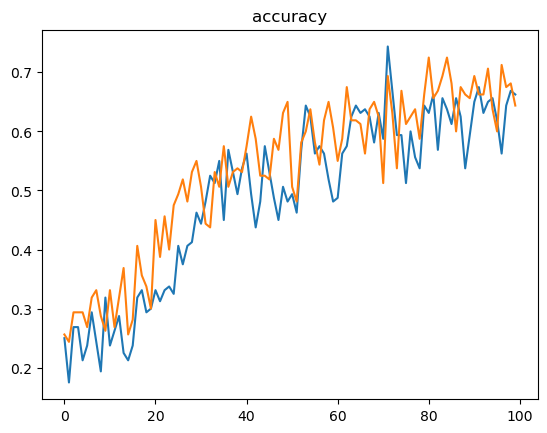

loss: 0.5682925581932068 iteration: 1100/2000


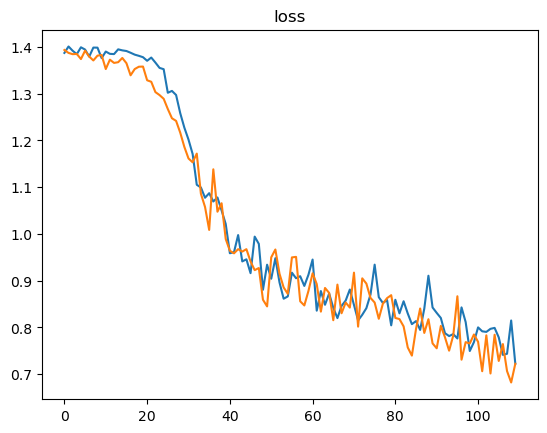

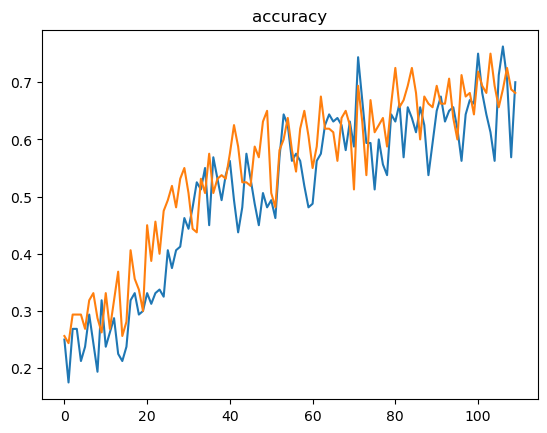

loss: 0.5043874979019165 iteration: 1200/2000


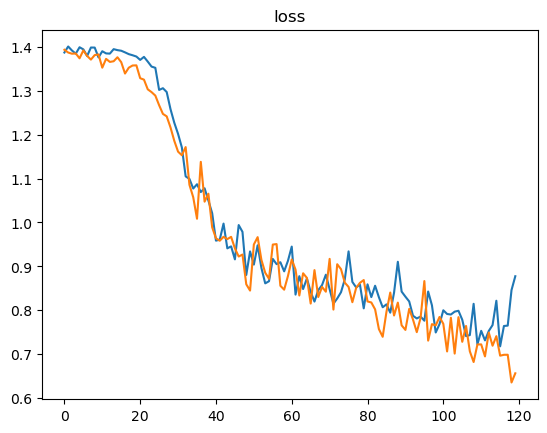

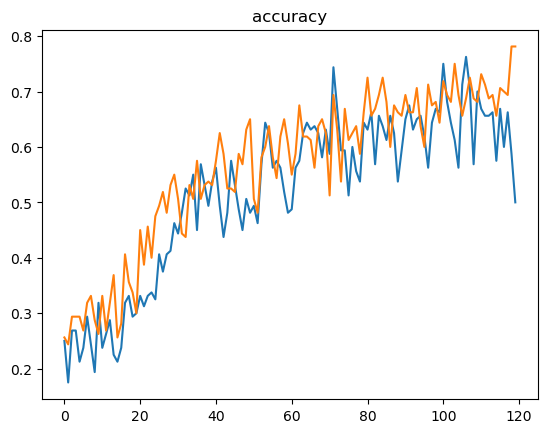

loss: 0.8502681851387024 iteration: 1300/2000


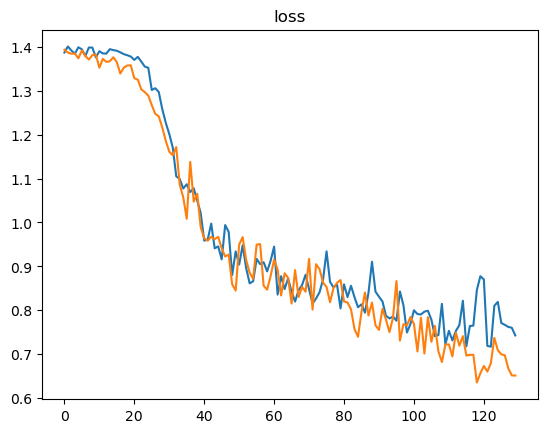

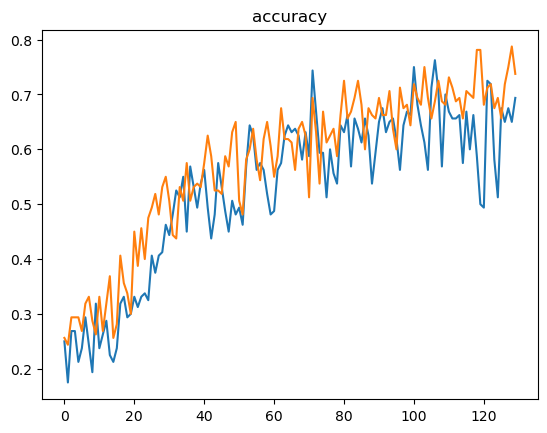

loss: 0.7053850293159485 iteration: 1400/2000


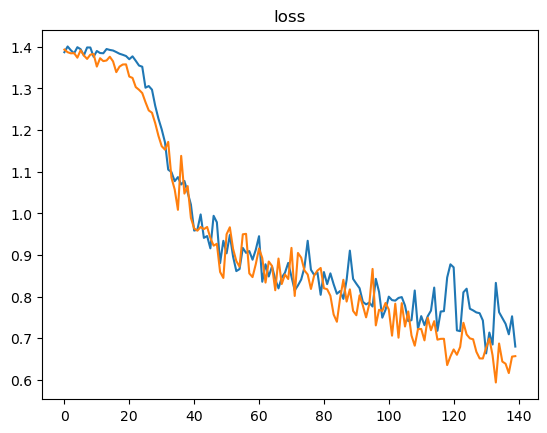

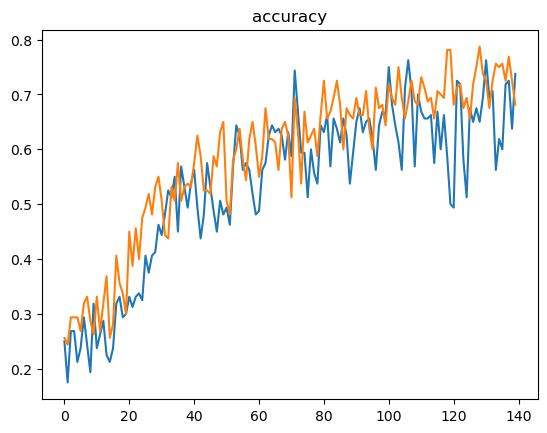

loss: 0.5591254830360413 iteration: 1500/2000


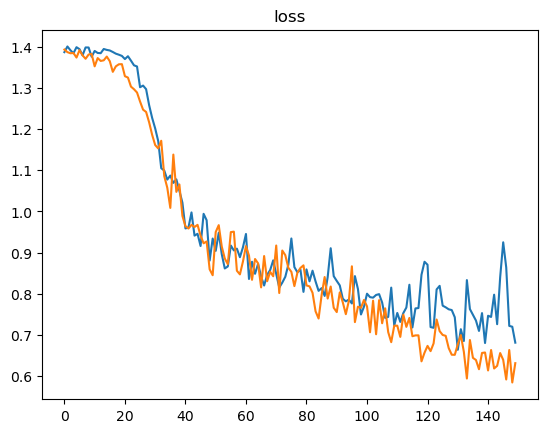

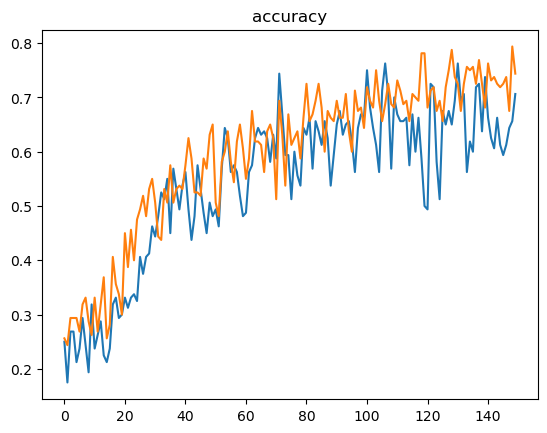

loss: 0.8289834260940552 iteration: 1600/2000


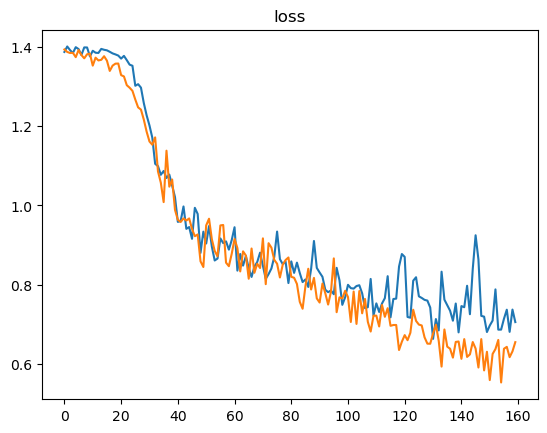

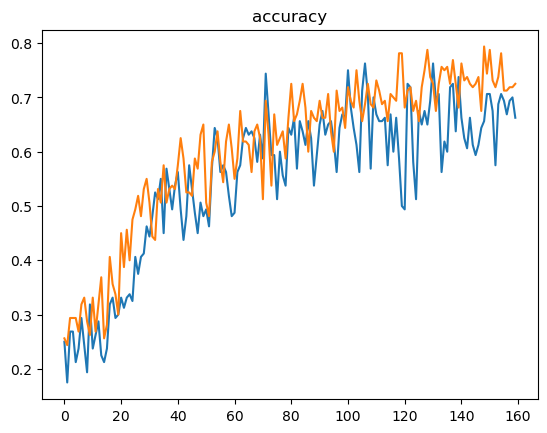

loss: 0.4101821780204773 iteration: 1700/2000


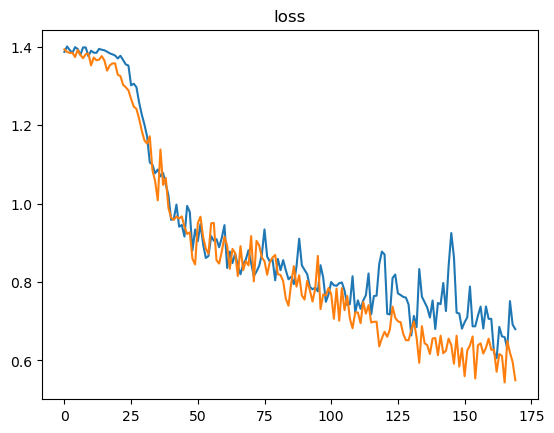

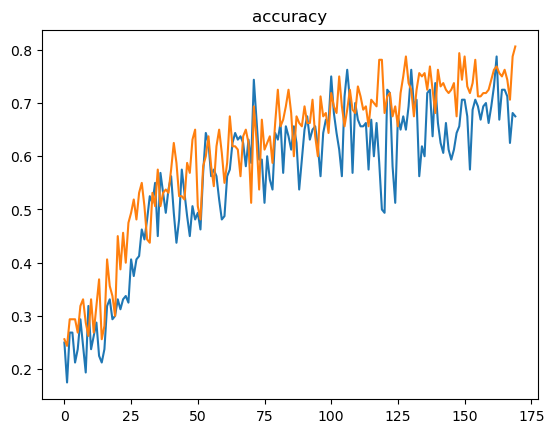

loss: 0.4286912679672241 iteration: 1800/2000


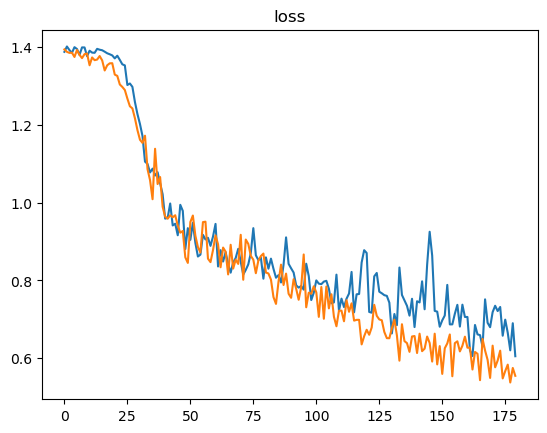

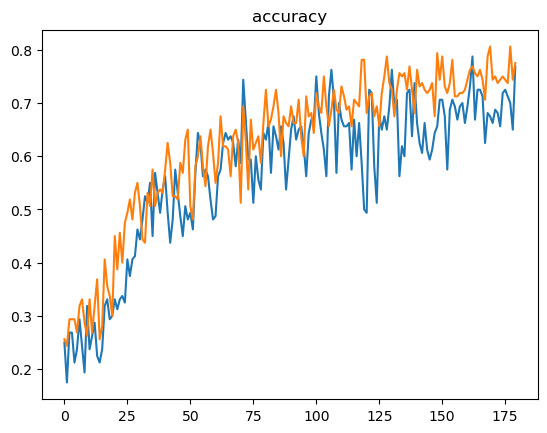

In [ ]:
from modules.TrainTester import TrainerTester

ud = []

#main-trianing-loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index],
    y_train, y_test = y[train_index], y[test_index]

    TrainerTester.train_loop(model, optimizer, X_train, y_train, X_test, y_test, lr, ud, batch_size=16, iterations=2000)

    out_values = TrainerTester.test_loop(model, X_test, y_test)
    break

In [ ]:
#params evaluation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, np.prod(param.size()))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total: ', params)

In [ ]:
# model.load_state_dict(torch.load('model_states/test_model_states.txt'))
# torch.save(model.state_dict(), 'model_states/test_model_states.txt')